In [7]:
# https://www.kaggle.com/uds5501/chicago-crime-mapping

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [8]:
df = pd.read_csv('data/chicago/Chicago_Crimes_2012_to_2017.csv')
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [9]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Having a look at the null values in our dataset

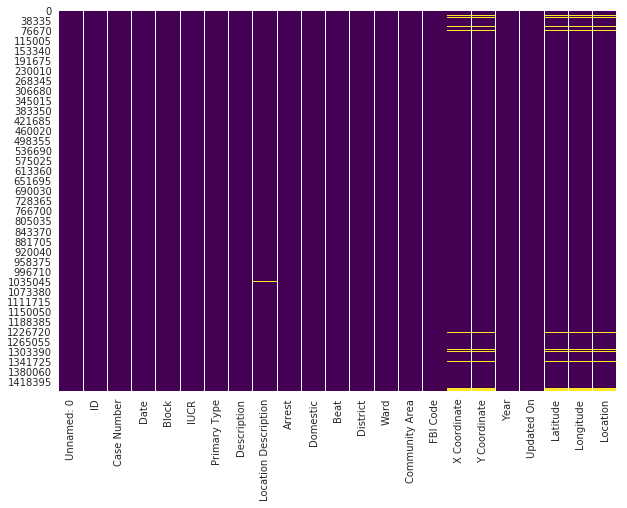

In [10]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')

In [11]:
df = df.dropna()
df = df.drop(columns=['Unnamed: 0', 'ID', 'Case Number', 'Block', 'IUCR','Domestic', 'Beat', 'District', 'Ward','X Coordinate', 'Y Coordinate','Updated On', 'FBI Code'], axis = 1)

# A little self explanatory data exploration from our side.
Mostly focussing on the top 10 value counts available to us in terms of Location Description and the Primary Type of Crime

In [12]:
pd.value_counts(df['Location Description'])[:10]

STREET                            325084
RESIDENCE                         223854
APARTMENT                         179444
SIDEWALK                          158478
OTHER                              53474
PARKING LOT/GARAGE(NON.RESID.)     40907
ALLEY                              31239
RESIDENTIAL YARD (FRONT/BACK)      30209
SMALL RETAIL STORE                 28209
SCHOOL, PUBLIC, BUILDING           25474
Name: Location Description, dtype: int64

In [13]:
pd.value_counts(df['Primary Type'])[:10]

THEFT                  321950
BATTERY                258941
CRIMINAL DAMAGE        152812
NARCOTICS              131177
ASSAULT                 89508
OTHER OFFENSE           85361
BURGLARY                81668
DECEPTIVE PRACTICE      67609
MOTOR VEHICLE THEFT     59856
ROBBERY                 56092
Name: Primary Type, dtype: int64

# Location Description and it's semantics

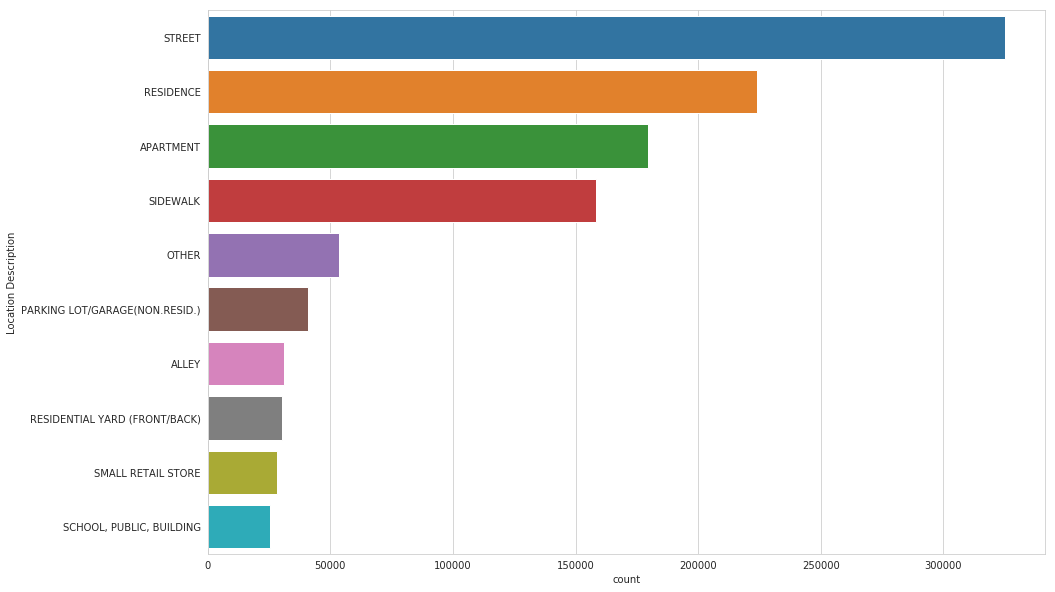

In [14]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location Description', data = df, order = df['Location Description'].value_counts().iloc[:10].index)

In [15]:
chicago_map = folium.Map(location=[41.864073,-87.706819],
                        zoom_start=11,
                        tiles="CartoDB dark_matter")

In [16]:
locations = df.groupby('Community Area').first()

In [17]:
new_locations = locations.loc[:, ['Latitude', 'Longitude', 'Location Description', 'Arrest']]

In [18]:
new_locations.head()

,Latitude,Longitude,Location Description,Arrest
Community Area,,,,
0.0,41.799090,-87.790549,RESIDENCE-GARAGE,False
1.0,41.998131,-87.665814,SIDEWALK,False
2.0,41.999731,-87.705810,STREET,False
3.0,41.972843,-87.671127,HOSPITAL BUILDING/GROUNDS,False
4.0,41.981316,-87.695119,RESIDENTIAL YARD (FRONT/BACK),False


In [19]:
popup_text = """Community Index : {}<br
                Arrest : {}<br>
                Location Description : {}<br>"""

# Preparing the first map. 

### Using one location each in a particular community area

In [22]:
unique_locations = df['Location'].value_counts()

# A simple Criminal Rate Index DataFrame

In [24]:
CR_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations})
CR_index.index = range(len(unique_locations))
CR_index.head()

,Raw_String,ValueCount
0,"(41.883500187, -87.627876698)",2093
1,"(41.754592961, -87.741528537)",2082
2,"(41.979006297, -87.906463155)",1338
3,"(41.897895128, -87.624096605)",1319
4,"(41.742710224, -87.634088181)",1122


In [25]:
def Location_extractor(Raw_Str):
    preProcess = Raw_Str[1:-1].split(',')
    lat =  float(preProcess[0])
    long = float(preProcess[1])
    return (lat, long)

In [26]:
CR_index['LocationCoord'] = CR_index['Raw_String'].apply(Location_extractor)

In [27]:
CR_index  = CR_index.drop(columns=['Raw_String'], axis = 1)

# A Simple Chicago Mapping showing the total criminal rates.

( As per the number of total criminal rates)

In [28]:
%%time

chicago_map_crime = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

for i in range(500):
    lat = CR_index['LocationCoord'].iloc[i][0]
    long = CR_index['LocationCoord'].iloc[i][1]
    radius = CR_index['ValueCount'].iloc[i] / 45
    
    if CR_index['ValueCount'].iloc[i] > 1000:
        color = "#FF4500"
    else:
        color = "#008080"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               CR_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_map_crime)

CPU times: user 65.3 ms, sys: 3.9 ms, total: 69.2 ms
Wall time: 67.2 ms


# Having a closer look at the thefts 

In [30]:
df_theft = df[df['Primary Type'] == 'THEFT']

In [33]:
df_theft_data = pd.DataFrame({"Counts": df_theft['Description'].value_counts(), "Description" : df_theft['Description'].value_counts().index})

In [34]:
df_theft_data.reset_index(inplace=True)

In [35]:
df_theft_data = df_theft_data.drop(columns=['index'], axis = 1)
df_theft_data.head()

,Counts,Description
0,132848,$500 AND UNDER
1,72957,OVER $500
2,47527,FROM BUILDING
3,42450,RETAIL THEFT
4,9910,POCKET-PICKING


# Maybe a sorted array of counts would look good

In [37]:
%%time
df_theft['Date'] = pd.to_datetime(df_theft['Date'])

CPU times: user 34.9 s, sys: 111 ms, total: 35.1 s
Wall time: 28.1 s


/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
df_theft['Month'] = df_theft['Date'].apply(lambda x : x.month)

/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
theft_in_months = pd.DataFrame({"thefts" : df_theft['Month'].value_counts(), "month" : df_theft["Month"].value_counts().index}, index = range(12))

In [40]:
theft_in_months.fillna(0, inplace=True)
theft_in_months = theft_in_months.sort_values(['month'], ascending=[1])

In [41]:
theft_in_months.head()

,thefts,month
9,29039.0,1
11,25791.0,2
10,28556.0,3
8,31238.0,4
5,27630.0,5


# An overall monthly trend presented in a plate

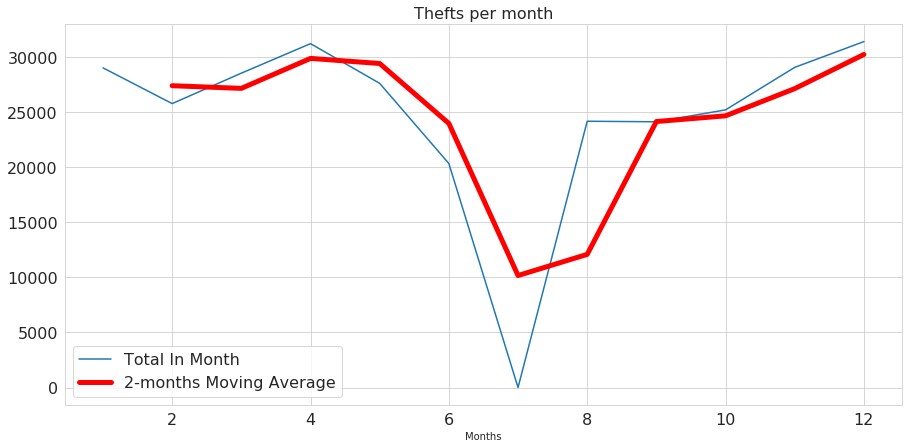

In [42]:
plt.figure(figsize = (15,7))
plt.plot(theft_in_months['month'],theft_in_months['thefts'], label = 'Total In Month')
plt.plot(theft_in_months['month'],theft_in_months['thefts'].rolling(window = 2).mean(),color='red', linewidth=5, label='2-months Moving Average' )

plt.title('Thefts per month', fontsize=16)
plt.xlabel('Months')
plt.legend(prop={'size':16})
plt.tick_params(labelsize=16);

In [43]:
print(max(df_theft['Date']))
print(min(df_theft['Date']))

2016-12-31 23:59:00
2012-01-01 00:00:00


In [44]:
df_theft['Date'].iloc[0].date()

datetime.date(2016, 5, 3)

In [45]:
df_theft_dates = df_theft['Location']
df_theft_dates.index = df_theft['Date']
resampled = df_theft_dates.resample('D')
df_theft_dates['MEAN'] = resampled.size().mean()
df_theft_dates['STD'] = resampled.size().std()


/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/home/hamdi_ug/anaconda3/envs/sfylab/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(

In [46]:
UCL = df_theft_dates['MEAN'] + 3 * df_theft_dates['STD']
LCL = df_theft_dates['MEAN'] -  3 * df_theft_dates['STD']

CPU times: user 2.03 s, sys: 876 µs, total: 2.03 s
Wall time: 59.2 ms


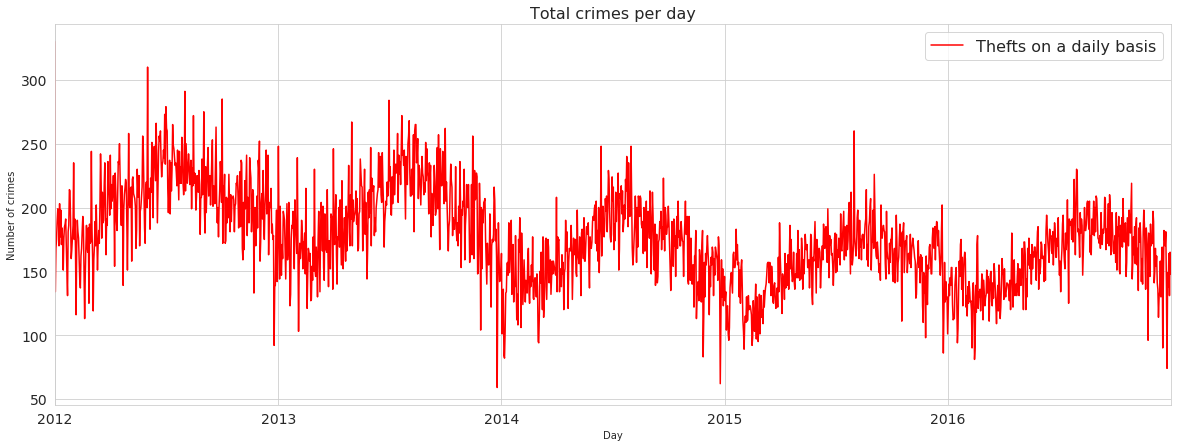

In [47]:
%%time

plt.figure(figsize=(20, 7))
resampled.size().plot(label = "Thefts on a daily basis", color = 'red')
# plt.plot(y = UCL,x = resampled.index, color='red', ls='--', linewidth=1.5, label='UCL')

# LCL.plot(color='red', ls='--', linewidth=1.5, label='LCL')
# df_theft_dates['MEAN'].plot(color='red', linewidth=2, label='Average')

plt.title('Total crimes per day', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Number of crimes')
plt.tick_params(labelsize=14)
plt.legend(prop={'size':16})

In [48]:
resampled.size().std()

35.51286962858635

# As you may have noticed, the yearly crime statistics follow a general trend.

Here, the noticable trend is a rise in curve at the start of the year and achieveing the peak at the mid point. somehwhere at **June - July** . After that it has an equally sharp drop to the initial number of crimes as the year started!